# Reinforcement Learning

## Introduction

### From Unsupervised to Supervised Learning

Unsupervised learning allows a model to discover structure present in the environment. This is a powerful way to build up a *neutral* representation of the world. But a representation generated by unsupervised learning does not have any valence (positive or negative value) - it does not tell you what things in the world are good or bad for you. Such a representation might help you infer what to expect,but it does not tell you what to do.  We need a way to learn how to behave - how to make better decisions and act to optimize rewards (increase positive outcomes, decrease negative outcomes).

Attaching value to things in the world, and making decisions that can arrive at these values introduces a key opportunity for training.  Supervised learning introduces the concepts of correct and incorrect, better and worse. In supervised learning the ends alter the means; the valenced outcome can reach back to change the processing that lead up to that outcome -- and when this learning works, it leads to better future decisions and outcomes.                       


## Predictions are Hard

At first pass, the only way to make accurate predictions is to travel backward in time. When you first receive a chocolate icecream cone your entire life lead up to this momentous occasion - what part of your life should be credited as its predictor?  Less extravagantly, even the few minutes before getting the icecream your natural environment contained an incredible amount of information and your brain cycled through a vast number of different states.  What feature of the environment might guide you to future icecream cones?  Which stimuli and brain states were the predictors?  Figuring this out is known as the *credit assignment problem*; it's an extremely hard problem to solve, and we'll return to it repeatedly in this course.

In order to survive, animals need to pursue rewarding things like food and avoid harmful things like getting attacked by other animals. Any ability to predict reward or punishment is generally helpful. Prediction requires associating a reward or punishment with things that consistently precede it.  If seeing over-ripe fruit on the ground is correlated with later finding ripe fruit above in the tree, the neutral stimulus of rotting fruit on the ground should teach you to look up for a rewarding piece of ripe fruit. (In behaviorist jargon, the rotting fruit on the ground begins as a neutral stimulus, looking up begins as an unconditioned response and the fruit in the tree is an unconditioned stimulus -- after learning, the rotting fruit is a conditioned stimulus and looking up is a conditioned response.) If an animal growling is correlated with that animal then attacking, hearing growling should make you prepare for an attack.  

How might animals learn to accurately predict rewards? Neural activity associated with a reward could gradually become associated with stimuli that precede the reward. Remember that with Hebbian Learning "neurons that fire together, wire together" and this can operate over both **spatial and temporal proximity**. Temporal proximity can potentially give us prediction. If a small red circle always appears right before a large chocolate icecream cone, the reward signal produced by the icecream cone could eventually become correlated with the small red circle.   
        

## Temporal Difference Learning

Temporal difference learning is a method that facilitates the backward propagation of predictions through a temporal representation. While it does not literally enable predictions to travel backward in time, it effectively allows them to update prior estimates based on subsequent outcomes, refining the temporal representation of events.

We start with a temporal sequence of stimuli: A->B->C->D. Let's call stimuli distributed over time *events*. Hebbian learning allows us to build up a neutral representation of this temporal sequence of events. Now, at time point D you get a reward. We want to associate the earliest event that reliably predicts this reward with the reward. Temporal difference learning is a way to transfer the prediction backward from D to C, from C to B, and ultimately from B to A.  


The key to understanding temporal difference learning is to shift from viewing time as a chronological construct to conceptualizing it as a linear sequence of events. This linear representation consists of stimulus events interspersed with intervals of waiting. If we imagine time flowing from left (past) to right (future), the objective is to enable information about rewards to propagate from right (future) to left (past) in order to generate accurate predictions.

## Code Examples

### Installation & Setup



In [ ]:
%%capture
!pip install psyneulink

In [9]:
import numpy as np
import psyneulink as pnl
import matplotlib.pyplot as plt 

### Temporal Difference Learning from Prediction Errors 
In this lab, we will be recreating the model of mesolimbic dopamine cell activity during monkey conditioning proposed by [Montague, Dayan, and Sejnowski (1996)](http://www.jneurosci.org/content/jneuro/16/5/1936.full.pdf). This model compares temporal difference learning from prediction errors to physiological data. We'll use this model to replicate Figure 5 from the paper.

![Montague et al., 1996, Figure 5](https://younesstrittmatter.github.io/502B/_static/images/montague_fig_5.jpg)

Figure 5A is plots of ∂(t) over time for three trials during training (1, 30, and 50), where $∂(t) = r(t) + w(t)x(t) - w(t - 1)x(t - 1)$ is the difference between the stimulus value and the reward.

For this experiment, the stimulus (a light) starts at timestep 41 and continues for the remainder of the trial, and the reward is delivered at timestep 54, so we'll create variables to represent that. Next, we'll create the arrays that represent the samples and targets. The sample values in this experiment stay the same across all trials, but the targets do not; every 15 trials, the reward was withheld.

In [36]:
def build_stimulus(n_trials, n_time_steps, no_reward_trials, stimulus_onset=41, reward_delivery=54):
    samples = []
    targets = []
    for trial in range(n_trials):
        # Samples (1 for stimulus_onset to end, 0 otherwise)
        sample = [0.] * n_time_steps
        for i in range(stimulus_onset, len(sample)):
            sample[i] = 1.
        samples.append(sample)
        
        # Targets (0 for all time steps except reward_delivery)
        target = [0.] * n_time_steps
        target[reward_delivery] = 1.
        if trial in no_reward_trials:
            target[reward_delivery] = 0.
        targets.append(target)

        

    return np.array(samples), np.array(targets)

In [37]:
n_time_steps = 60
n_trials = 120
no_reward_trials = {14, 29, 44, 59, 74, 89}
samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials)

In [38]:
# We can print the samples and targets

print(f'Samples ({samples.shape}):')
print(samples)
print(f'Targets ({targets.shape}):')
print(targets)

Samples ((120, 60)):
[[0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]
Targets ((120, 60)):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


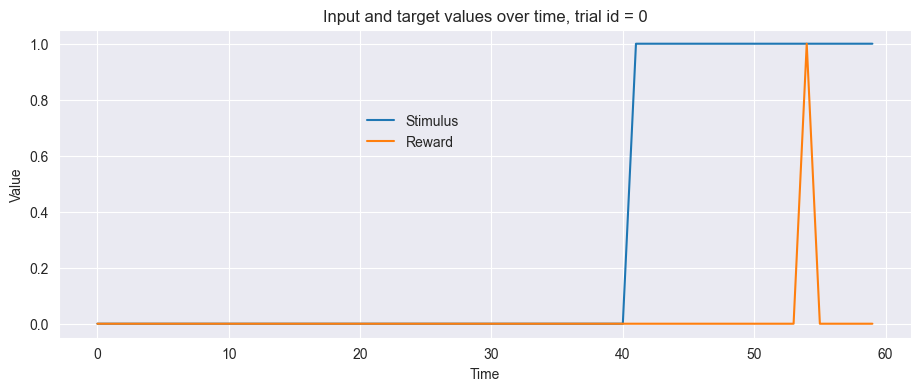

In [39]:
# We can also visualize the samples and targets for a specific trial with a line plot

trial_id = 0  # Try other ids, what do you expect to see for trial_id = 74?

f, ax = plt.subplots(1, 1, figsize=(11,4))
ax.plot(samples[trial_id,], label='Stimulus')
ax.plot(targets[trial_id,], label='Reward')

ax.set_title(f'Input and target values over time, trial id = {trial_id}')
ax.set_ylabel('Value')
ax.set_xlabel('Time')
f.legend(bbox_to_anchor=(.5,.7),frameon=False)

Text(0.5, 0, 'Time')

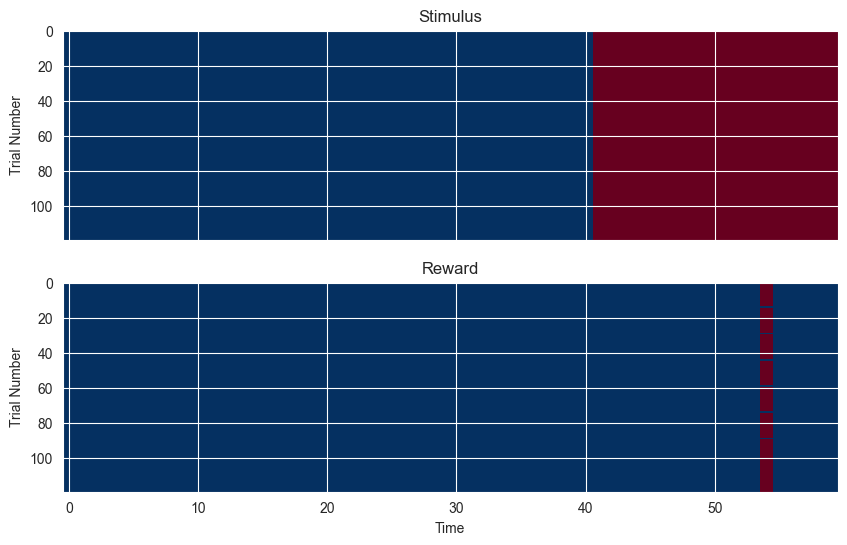

In [40]:
# Or with a heatmap (for all trials)

f, axes = plt.subplots(2, 1, figsize=(10,6), sharex=True)

axes[0].imshow(samples, cmap='RdBu_r', aspect='auto', interpolation='none', vmin=0, vmax=1)
axes[0].set_ylabel('Trial Number')
axes[0].set_title('Stimulus')

axes[1].imshow(targets, cmap='RdBu_r', aspect='auto', interpolation='none', vmin=0, vmax=1)
axes[1].set_ylabel('Trial Number')
axes[1].set_title('Reward')
axes[1].set_xlabel('Time')

Here, we create the model described in [Montague, Dayan, and Sejnowski (1996)](http://www.jneurosci.org/content/jneuro/16/5/1936.full.pdf). The model consists of a sample mechanism that represents the stimulus input, an action selection mechanism that represents the reward. These mechanisms are connected by a mapping projection. The projection weights are updated using temporal difference learning. The model is trained on the samples and targets we created earlier.

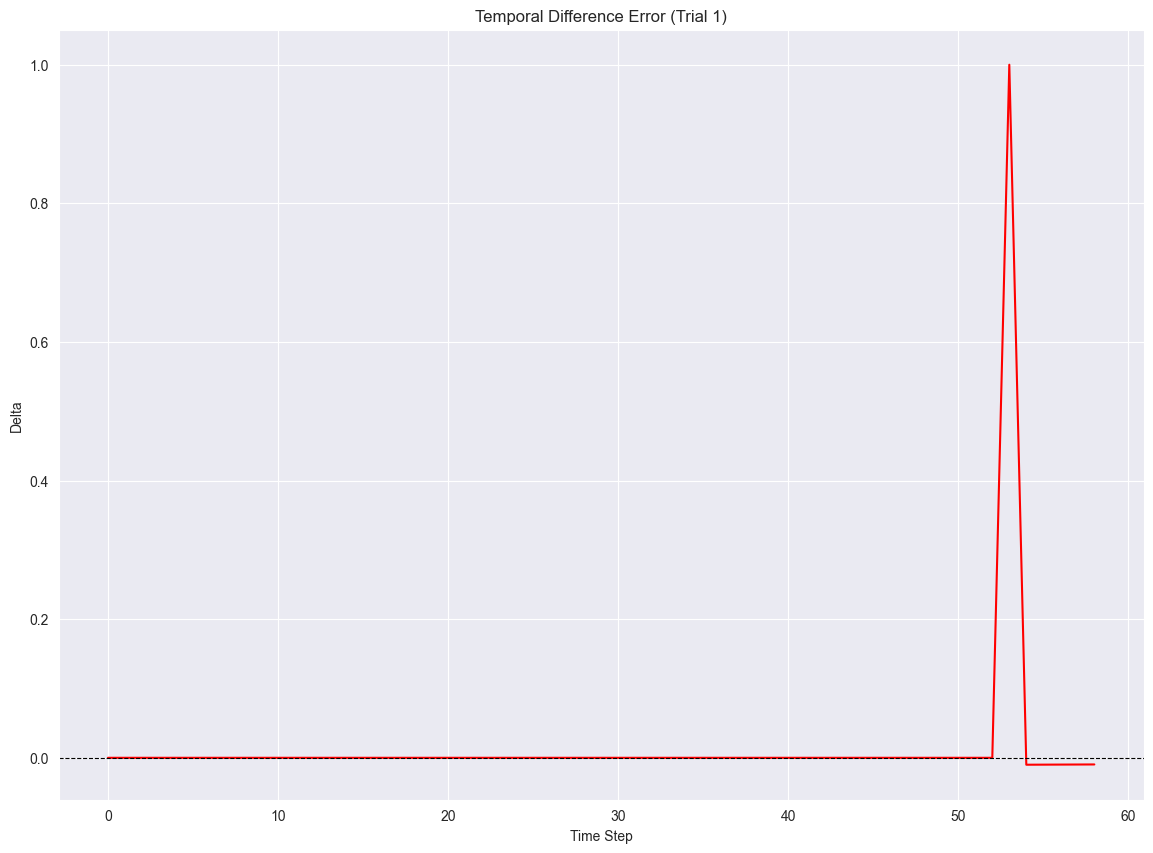

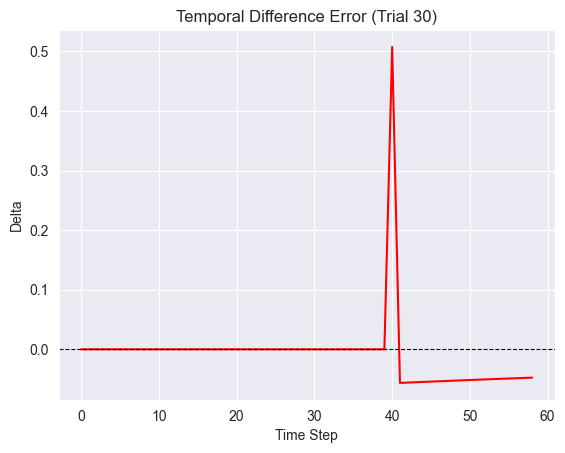

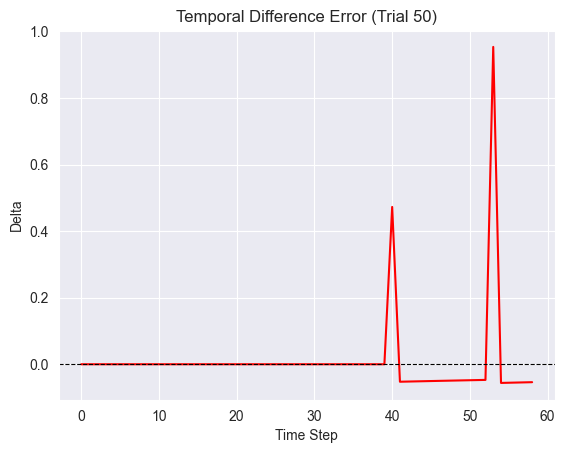

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def temporal_difference_learning_variable_trials(
    stimuli, rewards, alpha=0.3, gamma=1.
):
    """
    Temporal Difference (TD) learning with a different stimulus and reward per trial.

    Parameters
    ----------
    stimuli : list of lists or np.ndarray
        A list where each element is a stimulus vector for one trial (e.g., [0, 0, ..., 1, 1]).
    rewards : list of lists or np.ndarray
        A list where each element is a reward vector for one trial (e.g., [0, 0, ..., 1, 0, ...]).
    alpha : float
        Learning rate for TD learning.
    gamma : float
        Discount factor for future rewards.

    Returns
    -------
    weights : list of lists
        Learned weights at each time step for every trial.
    predictions : list of lists
        Predicted values at each time step for every trial.
    deltas : list of lists
        Temporal difference errors at each time step for every trial.
    """
    n_trials = len(stimuli)  # Number of trials
    n_steps = len(stimuli[0])  # Number of time steps per trial

    w = 0  # Initialize weight for the stimulus
    trial_weights = []  # Store weights for each trial
    trial_predictions = []  # Store predictions for each trial
    trial_deltas = []  # Store deltas for each trial

    for trial in range(n_trials):
        # Get stimulus and reward for the current trial
        stimulus = stimuli[trial]
        reward = rewards[trial]

        # Initialize lists to store results for the current trial
        weights = []
        predictions = []
        deltas = []

        for t in range(n_steps - 1):  # TD update for each time step
            x_t = stimulus[t]  # Stimulus at time t
            r_t1 = reward[t + 1]  # Reward at time t+1

            # Prediction at time t
            v_t = w * x_t

            # Prediction at time t+1
            v_t1 = w * stimulus[t + 1]

            # TD Error
            delta_t = r_t1 + gamma * v_t1 - v_t

            # Update weight
            w += alpha * delta_t * x_t

            # Store results
            weights.append(w)
            predictions.append(v_t)
            deltas.append(delta_t)

        # Add results from the final time step
        predictions.append(w * stimulus[-1])
        weights.append(w)

        # Store results for the current trial
        trial_weights.append(weights)
        trial_predictions.append(predictions)
        trial_deltas.append(deltas)

    return trial_weights, trial_predictions, trial_deltas


# Example Usage
n_time_steps = 50
n_trials = 3  # Simulate 3 different trials

# Stimuli and rewards for each trial
n_time_steps = 60
n_trials = 120
no_reward_trials = {14, 29, 44, 59, 74, 89}
stimuli, rewards = build_stimulus(n_trials, n_time_steps, no_reward_trials)

# Run Temporal Difference Learning
trial_weights, trial_predictions, trial_deltas = temporal_difference_learning_variable_trials(
    stimuli, rewards, alpha=0.1, gamma=0.9
)

# Plot Results
plt.figure(figsize=(14, 10))

# TD Error (Deltas) Across Trials
for trial in range(n_trials):
    if trial in [0, 29, 49]:
        plt.plot(trial_deltas[trial], label=f"TD Error (Trial {trial + 1})", color="red")
        plt.axhline(0, linestyle="--", color="black", linewidth=0.8)
        plt.title(f"Temporal Difference Error (Trial {trial + 1})")
        plt.xlabel("Time Step")
        plt.ylabel("Delta")
        plt.show()


In [48]:
learning_rate = .3

# Create the composition
composition_name = 'TD_Learning_Figure_5A'
comp = pnl.Composition(name=composition_name)

# Create Processing Components
sample_mechanism = pnl.TransferMechanism(
    input_shapes=samples.shape[1],
    name='Sample Mechanism')

action_selection = pnl.TransferMechanism(
    input_shapes=targets.shape[1],
    function=pnl.Linear(slope=1.0, intercept=0.01),
    name='Action Selection')

sample_to_action_selection = pnl.MappingProjection(matrix=np.zeros((60, 60)))

# Create pathway
pathway = [sample_mechanism, sample_to_action_selection, action_selection]

# Add Learning Components to the Composition
comp.add_td_learning_pathway(pathway, learning_rate=learning_rate, name='TD Learning Pathway')


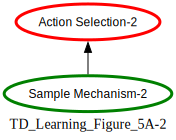

In [49]:
# Show the graph of the composition
comp.show_graph(output_fmt='jupyter')

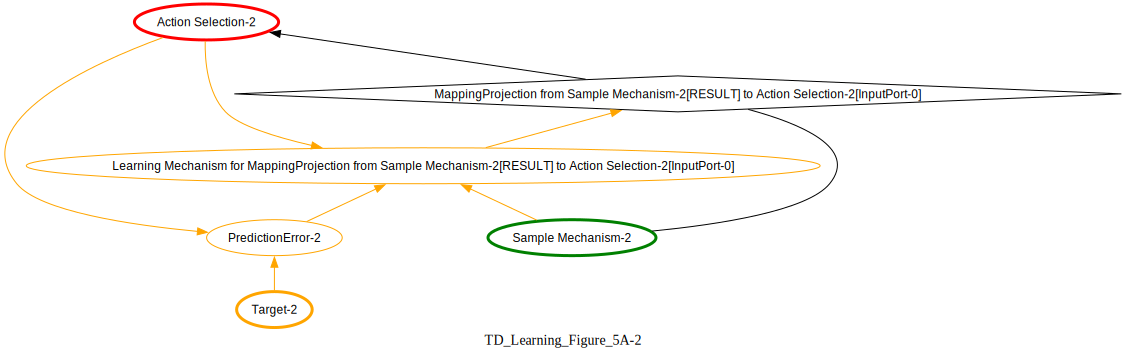

In [50]:
# Show the graph with learning
comp.show_graph(output_fmt='jupyter', show_learning=True)

In [51]:
comp = comp



In [53]:
# Build Stimuli and Targets
samples, targets = build_stimulus(n_trials, n_time_steps, no_reward_trials)

learning_pathway = comp.pathways[0]
learning_components = learning_pathway.learning_components

prediction_error_mechanism = learning_components[pnl.OBJECTIVE_MECHANISM]
prediction_error_mechanism.log.set_log_conditions(pnl.VALUE)

target_mechanism = learning_components[pnl.TARGET_MECHANISM]

input_dict = {
    sample_mechanism: samples,
    target_mechanism: targets
}

comp.learn(inputs=input_dict, context='execid')

(Composition TD_Learning_Figure_5A-2)


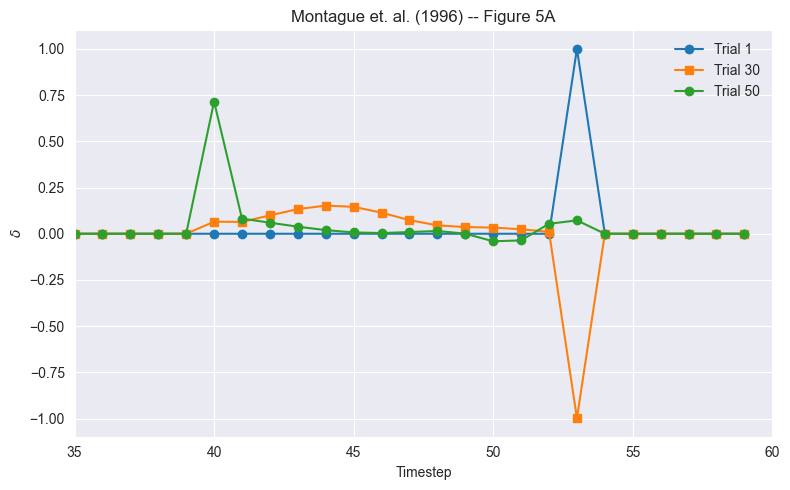

In [54]:
# Get Delta Values from Log
delta_vals = prediction_error_mechanism.log.nparray_dictionary()['execid'][pnl.VALUE]

# Plot Delta Values form trials 1, 30, and 50
t_start = 35
fig = plt.figure(figsize=(8, 5))
plt.plot(delta_vals[0][0], "-o", label="Trial 1")
plt.plot(delta_vals[29][0], "-s", label="Trial 30")
plt.plot(delta_vals[49][0], "-o", label="Trial 50")
plt.title("Montague et. al. (1996) -- Figure 5A")
plt.xlabel("Timestep")
plt.ylabel(r"$\delta$")
plt.legend(frameon=False)
plt.xlim([t_start, n_time_steps])
plt.xticks()
fig.tight_layout()